In [1]:
%load_ext autoreload
%autoreload 2

import os
import datetime as dt

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import models
import encoders
import decoders
from training import train, test, checkpoint, main_wandb, main_simple
from dataloaders import load_data, make_loaders, append_SOS

from MADE import MADE, main

import sys
sys.path.insert(0, '/scratch/users/udemir15/ELEC491/bassline_transcription')
from utilities import *

from bassline_transcriber.transcription import NN_output_to_MIDI_file

from plotting import F0_related_stem

from utilities import *

SEED = 27

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

wandb: Currently logged in as: raraz15 (use `wandb login --relogin` to force relogin)


cuda


In [21]:
M = 8

data_params = {'dataset_path': '/scratch/users/udemir15/ELEC491/bassline_transcription/data/datasets/[28, 51]',
               'dataset_name': 'TechHouse_bassline_representations_4020_augmented',
               #'dataset_name': 'TechHouse_bassline_representations',
               'scale_type': 'min',
               'M': M}

X, titles = load_data(data_params)
X = append_SOS(X)

K = int(X.max()+1) # Number of classes, assumes consecutive [0,max] inclusive
T = X.shape[1]

print('Number of classes: {}\nSequence Length: {}'.format(K, T))
print('Number of data points: {}'.format(X.shape[0]))

Number of classes: 27
Sequence Length: 65
Number of data points: 27862


In [22]:
train_params = {'batch_size': 32,
               'N_epochs': 10,
               'lr': 5e-4}

train_loader, test_loader = make_loaders(X, train_params['batch_size'])

In [23]:
embed_size = 12

embedding = nn.Embedding(K, embed_size).to(device)

transformer = nn.Transformer(d_model=embed_size, nhead=4).to(device)

fc_out = nn.Linear(embed_size, K).to(device)

#print(model)
print('Number of parameters: {}\n'.format(sum([parameter.numel() for parameter in model.parameters()])))

criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=train_params['lr'])

Number of parameters: 626544



In [24]:
model.train()

losses, accuracies  = [], []

for _ in range(train_params['N_epochs']):
    for source in train_loader:

        source = source[:,1:].to(device)

        optimizer.zero_grad()

        embedded = embedding(source).permute(1,0,2)

        activations = model(embedded, embedded)

        activations = fc_out(activations)

        loss = criterion(activations.permute(1,2,0), source)

        loss.backward()

        optimizer.step()
        loss.detach()

        losses.append(loss.item())

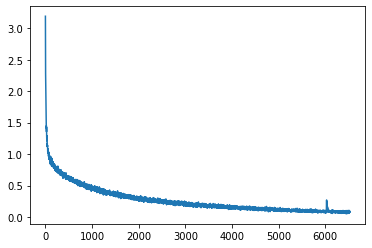

In [25]:
fig, ax = plt.subplots()
ax.plot(losses)

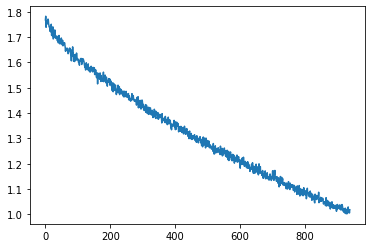

In [19]:
fig, ax = plt.subplots()
ax.plot(losses)

In [ ]:
output = model(embedded, embedded)

In [ ]:


train_loader, test_loader = make_loaders(X, train_params['batch_size'])

src = torch.rand((T, 32, 512))

out = transformer_model(src, tgt)